In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "ARR-B"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn064521,MKGKNVIQYFPLTASSSFLIHIDGVITTLGRTQPEIRLTQGTQEAS...,611,1
1,Achn066061,MTVEEIRGRLGGETDRFPVVTSTSQAKTALRMLRENQNRFDLVISD...,445,1
2,Achn096741,MASNKSTRVIFVNFTIEVEREYGSEIERIALSRVKPLRSEFLVYFA...,711,1
3,Achn099501,METGFSSPRTDAFPAGLRVLVVDDDLAWLRILEKMLKKCSYEVTTC...,592,1
4,Achn103181,MNFGVQGEKSMSMPSSSASWKCGDGVSDHFPVGLRVLVVDDDPTCL...,685,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
703,0.001771,0.002657,0.001771,0.009743,0.001771,0.003543,0.000000,0.001771,0.000886,0.002657,...,0.001771,0.000886,0.001771,0.000886,0.000000,0.000886,0.002657,0.0,0.0,0.001771
3990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004367,0.004367,...,0.004367,0.000000,0.000000,0.004367,0.004367,0.000000,0.004367,0.0,0.0,0.000000
4244,0.012174,0.000000,0.005217,0.003478,0.000000,0.000000,0.001739,0.005217,0.001739,0.008696,...,0.005217,0.000000,0.000000,0.001739,0.000000,0.000000,0.000000,0.0,0.0,0.001739
4127,0.056738,0.000000,0.007092,0.003546,0.003546,0.010638,0.000000,0.003546,0.000000,0.007092,...,0.000000,0.003546,0.007092,0.003546,0.000000,0.000000,0.000000,0.0,0.0,0.010638
3205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009615,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3741, 441)
X_test: (936, 441)
y_train: (3741,)
y_test: (936,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 21s 469ms/step - accuracy: 0.5156 - loss: 0.6932

34/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5962 - loss: 0.6799   

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6380 - loss: 0.6622 - val_accuracy: 0.9640 - val_loss: 0.2810


Epoch 2/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.2898

36/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9601 - loss: 0.1910

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9615 - loss: 0.1748 - val_accuracy: 0.9826 - val_loss: 0.0480


Epoch 3/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0369

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9867 - loss: 0.0439

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9857 - loss: 0.0461 - val_accuracy: 0.9733 - val_loss: 0.0651


Epoch 4/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0838

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0381

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9890 - loss: 0.0379 - val_accuracy: 0.9853 - val_loss: 0.0453


Epoch 5/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9531 - loss: 0.1482

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.0386

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9892 - loss: 0.0351 - val_accuracy: 0.9880 - val_loss: 0.0292


Epoch 6/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0268

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0241

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0242 - val_accuracy: 0.9893 - val_loss: 0.0293


Epoch 7/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0031

34/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0103

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0112 - val_accuracy: 0.9866 - val_loss: 0.0311


Epoch 8/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0053

34/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0073

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0090 - val_accuracy: 0.9853 - val_loss: 0.0391


Epoch 9/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0099

31/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0090

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0104 - val_accuracy: 0.9773 - val_loss: 0.0512


Epoch 10/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0032

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0045

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0056 - val_accuracy: 0.9746 - val_loss: 0.0798


Epoch 11/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0042

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0036

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0048 - val_accuracy: 0.9760 - val_loss: 0.0688


Epoch 12/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0012

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0105

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9970 - loss: 0.0107 - val_accuracy: 0.9720 - val_loss: 0.1144


Epoch 13/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0164

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0221

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0206 - val_accuracy: 0.9866 - val_loss: 0.0352


Epoch 14/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0040

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0048

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0046 - val_accuracy: 0.9880 - val_loss: 0.0346


Epoch 15/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.2417e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0019    

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0020 - val_accuracy: 0.9853 - val_loss: 0.0403


Epoch 16/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0366

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0098

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0081 - val_accuracy: 0.9813 - val_loss: 0.0546



[Train Accuracy: 99.80% - Test Accuracy: 98.72%]


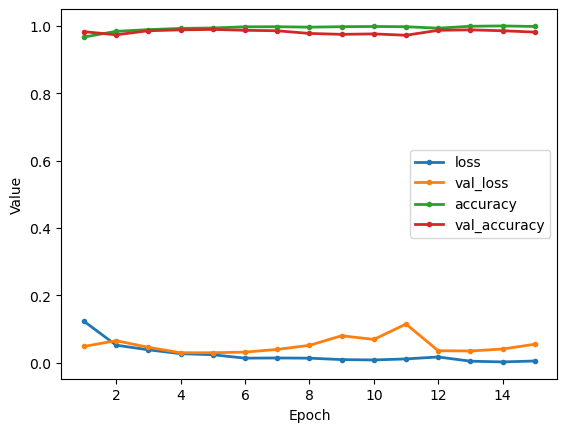

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step


 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
703,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000887,...,0.0,0.0,0.000000,0.000000,0.0,0.000887,0.000887,0.0,0.0,0.000000
3990,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
4244,0.003484,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.001742,0.0,0.001742,...,0.0,0.0,0.000000,0.001742,0.0,0.000000,0.000000,0.0,0.0,0.000000
4127,0.028470,0.0,0.0,0.003559,0.003559,0.003559,0.0,0.000000,0.0,0.003559,...,0.0,0.0,0.003559,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.003559
3205,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3741, 8707)
X_test: (936, 8707)
y_train: (3741,)
y_test: (936,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,229,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,272,513 (8.67 MB)

 Trainable params: 2,272,513 (8.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 24s 537ms/step - accuracy: 0.4531 - loss: 0.6932

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4922 - loss: 0.6927   

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4981 - loss: 0.6917

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5219 - loss: 0.6893

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5588 - loss: 0.6845

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5977 - loss: 0.6749

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6205 - loss: 0.6654 - val_accuracy: 0.9907 - val_loss: 0.2534


Epoch 2/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.2388

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9950 - loss: 0.2040 

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9938 - loss: 0.1753

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9928 - loss: 0.1543

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9917 - loss: 0.1394

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9914 - loss: 0.1276

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9913 - loss: 0.1189 - val_accuracy: 0.9947 - val_loss: 0.0193


Epoch 3/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0050

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0059 

18/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0053

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0054

35/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0054

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0053

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0053 - val_accuracy: 0.9960 - val_loss: 0.0183


Epoch 4/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0106

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0064 

18/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0046

27/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0038

35/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0034

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0031

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9947 - val_loss: 0.0162


Epoch 5/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.3284e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0016     

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0016

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0016

34/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0016

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0016

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9973 - val_loss: 0.0165


Epoch 6/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.6253e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9245e-04 

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6729e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7466e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6945e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6367e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6687e-04 - val_accuracy: 0.9933 - val_loss: 0.0163


Epoch 7/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.9819e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8772e-04 

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.2343e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.2901e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.2422e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0954e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9456e-04 - val_accuracy: 0.9960 - val_loss: 0.0169


Epoch 8/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 6.3980e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4012e-04 

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5721e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6717e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8483e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9788e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0477e-04 - val_accuracy: 0.9960 - val_loss: 0.0220


Epoch 9/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.4498e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0378e-04 

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0160e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8817e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8185e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7777e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7477e-04 - val_accuracy: 0.9960 - val_loss: 0.0161


Epoch 10/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 8.2822e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1203e-04 

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9438e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8308e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7580e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6945e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6407e-04 - val_accuracy: 0.9960 - val_loss: 0.0167


Epoch 11/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.6839e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3834e-05 

18/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.4382e-05

27/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.7225e-05

36/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.1025e-05

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.3537e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4362e-05 - val_accuracy: 0.9960 - val_loss: 0.0163


Epoch 12/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.9597e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.6399e-05 

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.7392e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.6754e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6518e-05

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.5471e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7486e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7664e-05 - val_accuracy: 0.9933 - val_loss: 0.0165


Epoch 13/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.1745e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1906e-04 

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0747e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0358e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0047e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.7448e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6771e-05 - val_accuracy: 0.9973 - val_loss: 0.0180


Epoch 14/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.3883e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5062e-05 

18/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4060e-05

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.1750e-05

34/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.9859e-05

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.8501e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8271e-05 - val_accuracy: 0.9973 - val_loss: 0.0181


Epoch 15/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.6603e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3047e-05 

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3539e-05

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.1476e-05

37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.9483e-05

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.8886e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8841e-05 - val_accuracy: 0.9960 - val_loss: 0.0175



[Train Accuracy: 100.00% - Test Accuracy: 99.68%]


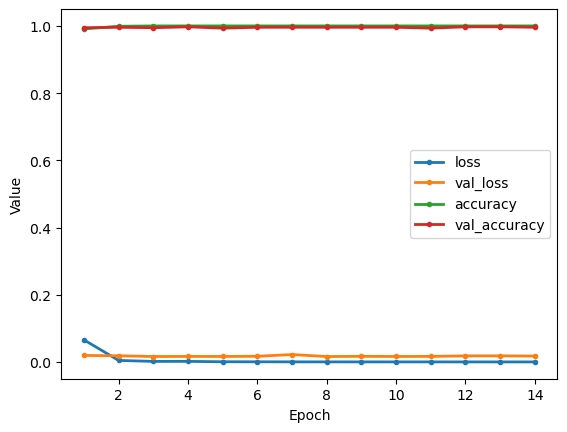

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
703,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3990,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4244,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.001745,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4127,0.017857,0.0,0.0,0.0,0.003571,0.0,0.0,0.000000,0.0,0.003571,...,0.0,0.0,0.0,0.003571,0.0,0.0,0.0,0.0,0.0,0.0
3205,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      36,352,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,393,473 (138.83 MB)

 Trainable params: 36,393,473 (138.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 31s 684ms/step - accuracy: 0.5781 - loss: 0.6931

 2/47 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.5352 - loss: 0.6933 

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5269 - loss: 0.6932

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.5143 - loss: 0.6933

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.5127 - loss: 0.6933

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.5136 - loss: 0.6932

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.5168 - loss: 0.6932

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.5218 - loss: 0.6931

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.5284 - loss: 0.6931

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.5349 - loss: 0.6930

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.5411 - loss: 0.6929

12/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5482 - loss: 0.6928

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.5550 - loss: 0.6927

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.5616 - loss: 0.6926

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.5680 - loss: 0.6925

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.5743 - loss: 0.6924

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.5804 - loss: 0.6923

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.5867 - loss: 0.6922

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.5929 - loss: 0.6920

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.5991 - loss: 0.6918

21/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.6052 - loss: 0.6917

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.6113 - loss: 0.6914

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.6172 - loss: 0.6912

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.6231 - loss: 0.6910

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.6288 - loss: 0.6907

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.6343 - loss: 0.6904

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.6395 - loss: 0.6901

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.6447 - loss: 0.6898

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.6496 - loss: 0.6894

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.6544 - loss: 0.6890

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6590 - loss: 0.6886

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6635 - loss: 0.6881

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6679 - loss: 0.6876

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6721 - loss: 0.6870

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6762 - loss: 0.6865

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6801 - loss: 0.6858

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6838 - loss: 0.6852

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6875 - loss: 0.6845

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6909 - loss: 0.6838

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6943 - loss: 0.6830

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6976 - loss: 0.6822

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7008 - loss: 0.6813

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7040 - loss: 0.6803

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7070 - loss: 0.6793

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7100 - loss: 0.6783

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7129 - loss: 0.6772

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7158 - loss: 0.6760

47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.7185 - loss: 0.6749 - val_accuracy: 0.9533 - val_loss: 0.3610


Epoch 2/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 1.0000 - loss: 0.3290

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9961 - loss: 0.3339

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9939 - loss: 0.3300

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9925 - loss: 0.3258

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9921 - loss: 0.3210

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9917 - loss: 0.3156

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9916 - loss: 0.3097

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9914 - loss: 0.3045

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9914 - loss: 0.2994

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9915 - loss: 0.2944

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9915 - loss: 0.2894

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9912 - loss: 0.2848

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9911 - loss: 0.2804

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9908 - loss: 0.2763

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9907 - loss: 0.2723

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9905 - loss: 0.2684

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9904 - loss: 0.2645

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9903 - loss: 0.2606

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9902 - loss: 0.2569

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9900 - loss: 0.2533

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9899 - loss: 0.2498

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9899 - loss: 0.2462

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9898 - loss: 0.2428

24/47 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9898 - loss: 0.2394

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9898 - loss: 0.2361

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9899 - loss: 0.2329

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9899 - loss: 0.2297

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9899 - loss: 0.2266

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9900 - loss: 0.2236

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9900 - loss: 0.2206

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9901 - loss: 0.2178

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9901 - loss: 0.2150

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9901 - loss: 0.2123

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9902 - loss: 0.2097

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9902 - loss: 0.2071

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9903 - loss: 0.2046

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9903 - loss: 0.2022

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9903 - loss: 0.1999

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9904 - loss: 0.1976

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9904 - loss: 0.1954

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9905 - loss: 0.1933

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9905 - loss: 0.1911

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9905 - loss: 0.1891

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9906 - loss: 0.1871

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9906 - loss: 0.1851

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9907 - loss: 0.1832

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9907 - loss: 0.1813

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.9907 - loss: 0.1795 - val_accuracy: 0.9853 - val_loss: 0.0378


Epoch 3/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9844 - loss: 0.0171

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9883 - loss: 0.0142

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9905 - loss: 0.0135

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9919 - loss: 0.0128

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9929 - loss: 0.0121

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9936 - loss: 0.0115

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9942 - loss: 0.0112

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9947 - loss: 0.0110

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9951 - loss: 0.0107

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9954 - loss: 0.0104

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9957 - loss: 0.0102

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9960 - loss: 0.0099

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9962 - loss: 0.0097

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9964 - loss: 0.0095

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9965 - loss: 0.0093

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9967 - loss: 0.0091

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9968 - loss: 0.0089

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9970 - loss: 0.0088

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9971 - loss: 0.0086

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9972 - loss: 0.0085

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9973 - loss: 0.0084

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9974 - loss: 0.0083

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9975 - loss: 0.0082

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9975 - loss: 0.0081

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9976 - loss: 0.0080

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9977 - loss: 0.0079

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9977 - loss: 0.0078

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9978 - loss: 0.0077

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9979 - loss: 0.0076

30/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9979 - loss: 0.0075

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9980 - loss: 0.0074

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9980 - loss: 0.0074

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9981 - loss: 0.0073

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9981 - loss: 0.0072

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9981 - loss: 0.0072

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9982 - loss: 0.0071

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9982 - loss: 0.0070

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9983 - loss: 0.0070

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9983 - loss: 0.0069

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9983 - loss: 0.0068

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9984 - loss: 0.0068

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9984 - loss: 0.0067

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9984 - loss: 0.0066

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9984 - loss: 0.0066

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9985 - loss: 0.0065

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9985 - loss: 0.0065

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9985 - loss: 0.0064

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9985 - loss: 0.0064 - val_accuracy: 0.9933 - val_loss: 0.0209


Epoch 4/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0022

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0020

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 0.0020

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 0.0020

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 0.0020

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 0.0019

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 0.0019

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 0.0019

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 0.0019

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 0.0018

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 0.0018

12/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 0.0018

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 0.0018

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 0.0018

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 0.0018

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 0.0018

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 0.0018

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 0.0017

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 0.0017

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 0.0017

21/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 0.0017

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 0.0017

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 0.0017

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 0.0017

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 0.0017

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 0.0017

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 0.0016

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 0.0016

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 0.0016

30/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 0.0016

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 0.0016

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0016

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0016

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 0.0016

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0016

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0016

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0016

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0015

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0015

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0015

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0015

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 0.0015

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 0.0015

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 0.0015

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0015

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0015

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0015

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9933 - val_loss: 0.0201


Epoch 5/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 7.1557e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 8.9521e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 8.9536e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 8.9834e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 8.8991e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 8.7531e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 8.5803e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 8.4798e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 8.4540e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 8.4159e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 8.3864e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 8.3535e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 8.3648e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 8.3536e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 8.3365e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 8.3232e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 8.3013e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 8.2805e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 8.2541e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 8.2270e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 8.1969e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 8.1820e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 8.1636e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 8.1432e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 8.1238e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 8.1019e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 8.0766e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 8.0554e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 8.0324e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 8.0083e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 7.9835e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 7.9580e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 7.9305e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 7.9029e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 7.8813e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 7.8592e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 7.8374e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 7.8152e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.7961e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.7762e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.7589e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.7403e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.7206e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.7007e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.6802e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.6598e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.6401e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 7.6211e-04 - val_accuracy: 0.9933 - val_loss: 0.0222


Epoch 6/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 5.8289e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 6.1255e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 6.0319e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 5.9065e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.7685e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.7513e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.8059e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.8118e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.7887e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 5.7467e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 5.7060e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 5.6539e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 5.7152e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 5.7618e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 5.7922e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 5.8043e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 5.8077e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 5.8176e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 5.8247e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 5.8327e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 5.8403e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 5.8397e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 5.8333e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 5.8290e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 5.8208e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.8076e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.7933e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 5.7762e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.7570e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.7362e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.7152e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.6939e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.6727e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.6499e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.6284e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.6069e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.5843e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.5612e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.5396e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.5176e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.4965e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.4750e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.4535e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.4331e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.4129e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.3922e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.3717e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 5.3520e-04 - val_accuracy: 0.9920 - val_loss: 0.0223


Epoch 7/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 4.1846e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 3.5909e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 3.4401e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 3.2423e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 3.0749e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 2.9495e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 2.9239e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 2.9430e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 2.9434e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 2.9364e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 2.9166e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 2.8950e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 2.8772e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 2.8723e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 2.8715e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 2.8684e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.8652e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 2.8658e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.8649e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.8620e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.8629e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.8638e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.8638e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.8617e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.8605e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.8583e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.8571e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.8542e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.8510e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 2.8465e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 2.8413e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 2.8365e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 2.8321e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.8265e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.8207e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.8165e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.8119e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.8094e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 2.8072e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 2.8071e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.8075e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 2.8070e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 2.8058e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 2.8042e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 2.8029e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 2.8012e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.7993e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 2.7974e-04 - val_accuracy: 0.9933 - val_loss: 0.0197


Epoch 8/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 3.2189e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 2.7437e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 2.4730e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 2.2986e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 2.1735e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 2.0702e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.9823e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.9185e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.8882e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.8659e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.8447e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.8272e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.8109e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.7983e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.7906e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.7846e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.7802e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 1.7754e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.7692e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.7625e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.7545e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.7462e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.7380e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.7293e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.7217e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.7144e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.7078e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.7006e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.6938e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.6879e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.6839e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 1.6797e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.6753e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.6707e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.6668e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.6628e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.6607e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.6584e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.6582e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.6575e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.6586e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.6592e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.6600e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 1.6605e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 1.6612e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 1.6615e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 1.6615e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 1.6615e-04 - val_accuracy: 0.9920 - val_loss: 0.0231


Epoch 9/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 1.0917e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 1.1395e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 1.3246e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 1.4566e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 1.5029e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 1.5584e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.7826e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.9182e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 1.9997e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 2.0526e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 2.0846e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 2.1059e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 2.1194e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 2.1355e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 2.1531e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 2.1632e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 2.1692e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 2.1703e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 2.1683e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 2.1650e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.1596e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.1522e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.1438e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.1347e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.1242e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.1128e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.1017e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.0909e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.0793e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.0680e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.0569e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.0451e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.0340e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.0232e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.0128e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 2.0023e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.9916e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.9807e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.9698e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.9590e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.9488e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.9396e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.9311e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.9228e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.9144e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.9061e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.8979e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.8900e-04 - val_accuracy: 0.9933 - val_loss: 0.0214


Epoch 10/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 1.0000 - loss: 8.6173e-05

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 7.9039e-05

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 7.5436e-05

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 7.4806e-05

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 7.8834e-05

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 8.1284e-05

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 8.2779e-05

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 8.3812e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 8.4635e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 8.5442e-05

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 8.6381e-05

12/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 8.7373e-05

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 8.7974e-05

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 8.8670e-05

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 8.9239e-05

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 9.0298e-05

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 9.1263e-05

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 9.2156e-05

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 9.2835e-05

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 9.3376e-05

21/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 9.3926e-05

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 9.4357e-05

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 9.4637e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 9.4807e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 9.5007e-05

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 9.5128e-05

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 9.5147e-05

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 9.5115e-05

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 9.5097e-05

30/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 9.5014e-05

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 9.4996e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 9.4990e-05

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 9.4993e-05

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 9.4962e-05

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 9.5047e-05

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 9.5079e-05

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 9.5080e-05

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 9.5102e-05

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 9.5086e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 9.5046e-05

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 9.4972e-05

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 9.4875e-05

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 9.4762e-05

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 9.4680e-05

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 9.4581e-05

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 9.4474e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 9.4354e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 9.4239e-05 - val_accuracy: 0.9933 - val_loss: 0.0213


Epoch 11/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.4651e-05

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 3.9096e-05

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 5.4603e-05

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 6.2984e-05

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 6.6992e-05

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 6.9600e-05

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 7.0943e-05

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 7.1762e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 7.2261e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 7.2700e-05

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 7.2827e-05

12/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 7.2659e-05

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 7.2673e-05

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 7.2628e-05

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 7.2499e-05

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 7.2383e-05

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 7.2179e-05

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 7.2087e-05

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 7.1992e-05

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 7.1970e-05

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 7.2253e-05

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 7.2455e-05

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 7.3093e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 7.3605e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.4031e-05

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.4508e-05

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.4936e-05

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.5309e-05

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.5616e-05

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.5862e-05

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.6297e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.6699e-05

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.7057e-05

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.7396e-05

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.7681e-05

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.7903e-05

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.8093e-05

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.8263e-05

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 7.8392e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.8503e-05

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.8593e-05

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.8646e-05

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.8667e-05

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.8673e-05

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.8667e-05

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 7.8681e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 7.8749e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 7.8814e-05 - val_accuracy: 0.9933 - val_loss: 0.0220


Epoch 12/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 1.0000 - loss: 4.1329e-05

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 4.3197e-05

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 4.3797e-05

 4/47 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 4.3244e-05

 5/47 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 1.0000 - loss: 4.2380e-05

 6/47 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.1502e-05

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 4.0616e-05

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 4.0214e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 4.0074e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 4.0188e-05

11/47 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 4.0513e-05

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 4.0941e-05

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 4.1364e-05

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 4.1798e-05

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 4.2285e-05

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 4.2819e-05

17/47 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 4.3396e-05

18/47 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 4.4288e-05

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 4.5393e-05

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 4.6302e-05

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 4.7072e-05

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.7737e-05

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.8293e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 4.8789e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 4.9316e-05

26/47 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 4.9772e-05

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 5.0149e-05

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 5.0493e-05

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 5.0814e-05

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 5.1593e-05

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 5.2332e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 5.3001e-05

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 5.3624e-05

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 5.4182e-05

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 5.4704e-05

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 5.5209e-05

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 5.5671e-05

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 5.6093e-05

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 5.6498e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 5.6872e-05

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 5.7211e-05

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 5.7513e-05

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.7784e-05

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.8038e-05

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.8275e-05

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 5.8484e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 5.8675e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 5.8859e-05 - val_accuracy: 0.9933 - val_loss: 0.0213


Epoch 13/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 1.0000 - loss: 3.6871e-05

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 4.1935e-05

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 4.2045e-05

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 4.6818e-05

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 4.8946e-05

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 4.9531e-05

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 5.0326e-05

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 5.0621e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 5.0977e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 5.1660e-05

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 5.1925e-05

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 5.2028e-05

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 5.3053e-05

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 5.4498e-05

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 5.5609e-05

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 5.6522e-05

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 5.7260e-05

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 5.7888e-05

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 5.8509e-05

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 5.9030e-05

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 5.9421e-05

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 5.9744e-05

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 6.0037e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 6.0263e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 6.0762e-05

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.1188e-05

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.1535e-05

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.1821e-05

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.2030e-05

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.2208e-05

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.2352e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.2452e-05

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.2523e-05

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.2579e-05

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.2735e-05

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 6.2849e-05

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 6.2946e-05

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.3058e-05

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.3137e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 6.3190e-05

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.3235e-05

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.3252e-05

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.3266e-05

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 6.3270e-05

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 6.3261e-05

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 6.3238e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.3213e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 6.3190e-05 - val_accuracy: 0.9933 - val_loss: 0.0221



[Train Accuracy: 100.00% - Test Accuracy: 99.15%]


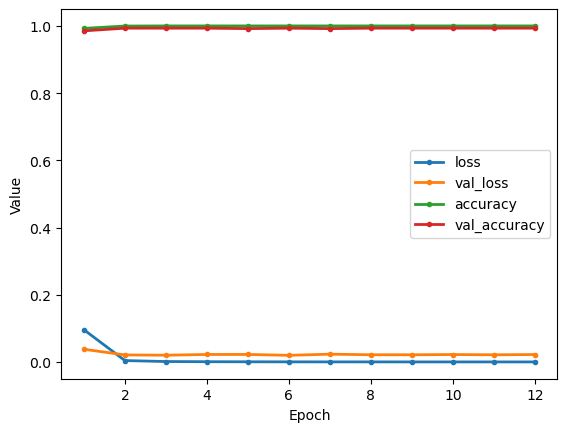

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

 7/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

12/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

18/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

24/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

 7/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

12/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

18/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

23/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [25]:
report.save()

Report saved as Output/Reports/ARR-B/report_SOGO8T2O.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################